In [3]:
import pandas as pd
import plotly.express as px
import datetime as dt
import numpy as np
df = pd.read_csv("train.csv",index_col=0)
df.Datum = pd.to_datetime(df["Datum"])
df.set_index(df["Datum"],inplace=True)

df["Arbeitszeit"] = (df["Datum"].dt.hour.between(8,17))&(df["Datum"].dt.dayofweek < 5)&~((df["Datum"].dt.hour==13)&(df["Datum"].dt.minute.between(0,15)))

#Leichte Glättung um Streuung besser abzubilden
df["Arbeitszeit"] = df["Arbeitszeit"].astype(int).ewm(com=10).mean() 

#Multikolinearität vermeiden; Laut Aufgabenstellung wird der Wassergehalt aus Luftfeuchtigkeit und Temperatur abgeleitet
df.drop(["Datum","Wassergehalt"],axis=1,inplace=True) 
df.dropna(inplace=True)


df_test = pd.read_csv("test.csv",index_col=0)
df_test.Datum = pd.to_datetime(df_test["Datum"])
df_test.set_index(df_test["Datum"],inplace=True)
df_test["Arbeitszeit"] = (df_test["Datum"].dt.hour.between(8,17))&(df_test["Datum"].dt.dayofweek < 5)&~((df_test["Datum"].dt.hour==13)&(df_test["Datum"].dt.minute.between(0,20)))
df_test.drop(["Datum","Wassergehalt"],axis=1,inplace=True)
df_test.dropna(inplace=True)

In [4]:
df.describe()

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit,Arbeitszeit
count,14225.000000,14225.000000,14225.000000,14225.000000,1.422500e+04
mean,21.005722,25.941156,628.075549,0.256591,2.934535e-01
std,1.148986,4.581969,279.382924,0.436767,4.445397e-01
min,19.000000,16.745000,412.750000,0.000000,9.502077e-155
25%,20.290000,22.675000,446.000000,0.000000,4.631667e-32
50%,20.830000,25.722500,512.000000,0.000000,6.872680e-14
75%,21.700000,28.650000,694.750000,1.000000,9.862808e-01
max,24.408333,39.117500,2028.500000,1.000000,1.000000e+00


## Ausreißer werden entfernt
- macht keinen großen Unterschied für die Performance aber etwas sauberer
- fehlende Werte füllen wir nicht auf weil es nicht genug Daten gibt um sie verlässlich intelligent zu füllen


In [5]:
features = ["Luftfeuchtigkeit", "Temperatur", "CO2"]
for feature in features:
    df[f"Ausreisserdropper{feature}"] = df[feature]/df[feature].shift(1)
#    df = df[~df["Ausreisserdropper"].between(0.998,1.002)]
#    cols = ['col_1', 'col_2'] # one or more
    Q1 = df[f"Ausreisserdropper{feature}"].quantile(0.04)
    Q3 = df[f"Ausreisserdropper{feature}"].quantile(0.96)
    IQR = Q3 - Q1
    df = df[~((df[f"Ausreisserdropper{feature}"] < (Q1 - 1.5 * IQR)) |(df[f"Ausreisserdropper{feature}"] > (Q3 + 1.5 * IQR)))]
#px.histogram(df[~df["Ausreisserdropper"].between(0.996,1.004)],x="Ausreisserdropper")
df.drop(columns=["AusreisserdropperTemperatur","AusreisserdropperLuftfeuchtigkeit","AusreisserdropperCO2"],inplace=True)
df.dropna(inplace=True)

df['Date'] = df.index.date
mask = df.Date != pd.to_datetime('2017-02-02')
df = df[mask]
df.drop(["Date"],axis=1,inplace=True)

<AxesSubplot:>

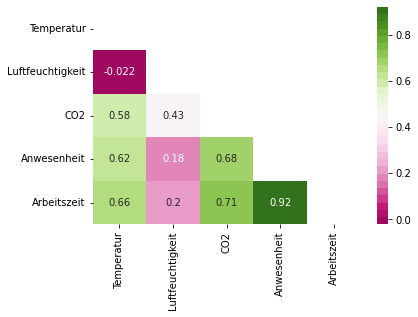

In [6]:
from seaborn import heatmap, color_palette
#heatmap(df.drop(columns="Anwesenheit").corr(),annot=True,cmap=color_palette("PiYG", 12))
heatmap(df.corr(),annot=True,cmap=color_palette("PiYG", 30),mask=np.triu(df.corr()))

#heatmap(df_test.corr(),annot=True,cmap=color_palette("PiYG", 12)) 
#Negativer statt positiver Zusammenhang für Luftfeuchtigkeit und CO2 bei den echten Testdaten!

In [7]:
px.bar(df.resample("10min").mean(),y="CO2",color="Arbeitszeit")

## Funktion fürs Training

In [8]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, plot_roc_curve,roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

label = "Anwesenheit"

def train_model(classifier,label=label,scaler=None):
    print(pd.DataFrame(columns=df.columns))
    X = df.drop(columns=[label])
    y = df[label]
    if scaler:
        X = scaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
    
    m = classifier(args)
    %time m.fit(X_train, y_train)
    print("Trainingsdaten:\n",classification_report(y_train,m.predict(X_train)))
    print("Testdaten:\n",classification_report(y_test,m.predict(X_test),digits=3))
    
    fpr, tpr, thresholds = roc_curve(y_test,m.predict(X_test))
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
    display.plot()

def report(m):
    print("Trainingsdaten:\n",classification_report(y_train,m.predict(X_train),digits=3))
    print("Testdaten:\n",classification_report(y_test,m.predict(X_test),digits=3))

def scale_features(scaler, X_train, X_test):
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

def test_viz(m):
    if 'Anwesenheit' in df_test:
        df_test.drop(columns="Anwesenheit",inplace=True)
    df_test["Anwesenheit"] = m.predict(df_test)
    px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
    df_test.drop(columns="Anwesenheit",inplace=True)

# Erste Modelle 

## Logistische Regression

In [9]:
# Erstellung eines einfachen df zum testen der ersten Modelle
df_e = df.drop(['Arbeitszeit'], axis = 1).reset_index()
df_e['Stunde'] = df_e.Datum.dt.hour
df_e['Wochenende'] = df_e.Datum.dt.day_of_week >= 5
df_e.head()

,Datum,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit,Stunde,Wochenende
0,2017-01-25 17:51:00,23.18,27.2720,721.25,1,17,False
1,2017-01-25 17:51:59,23.15,27.2675,714.00,1,17,False
2,2017-01-25 17:53:00,23.15,27.2450,713.50,1,17,False
3,2017-01-25 17:54:00,23.15,27.2000,708.25,1,17,False
4,2017-01-25 17:55:00,23.10,27.2000,704.50,1,17,False


In [10]:
X = df_e.drop(['Anwesenheit', 'Datum'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

print('Trainingsdaten:\n', classification_report(y_train, model.predict(X_train)))
print('Testdaten:\n', classification_report(y_test, model.predict(X_test)))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      7268
           1       0.87      0.83      0.85      2261

    accuracy                           0.93      9529
   macro avg       0.91      0.90      0.90      9529
weighted avg       0.93      0.93      0.93      9529

Testdaten:
               precision    recall  f1-score   support

           0       0.76      0.97      0.86      2047
           1       0.90      0.45      0.60      1130

    accuracy                           0.79      3177
   macro avg       0.83      0.71      0.73      3177
weighted avg       0.81      0.79      0.77      3177



### Verbesserung des Modells mit den Hyperparametern

In [11]:
# Extrahierung von X,y von den DF
X = df_e.drop(['Anwesenheit', 'Datum'], axis = 1)
y = df_e['Anwesenheit']

# Generierung der Dummy-Variablen aus Stunde
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
scale_features(MinMaxScaler, X_train, X_test)

lr = linear_model.LogisticRegression(max_iter=10000)
grid = {
# "solver" : ["newton-cg", "lbfgs", "sag", "saga"],
# "C": [100, 10, 1.0, 0.1, 0.01]
"solver" : ["lbfgs","newton-cg" ],
"C": [ 1.0, 0.1, 10]
}

# rsLR =  RandomizedSearchCV(estimator = lr, param_distributions = random_grid)
# rsLR.fit(X_train,y_train)
# print(rsLR.best_params_,"\n",rsLR.score(X_test, y_test))

clf = GridSearchCV(lr, grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

{'C': 10, 'solver': 'lbfgs'}
0.9150141643059491


In [12]:
# Model mit C = 10 und newton-cg als Solver
X = df_e.drop(['Anwesenheit', 'Datum'], axis = 1)
y = df_e['Anwesenheit']

# Generierung der Dummy-Variablen aus Stunde
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
scale_features(MinMaxScaler, X_train, X_test)

model = linear_model.LogisticRegression(C = 10, solver = 'newton-cg' )
model.fit(X_train, y_train)

report(model)

Trainingsdaten:
               precision    recall  f1-score   support

           0      0.976     0.977     0.977      7268
           1      0.925     0.924     0.925      2261

    accuracy                          0.964      9529
   macro avg      0.951     0.950     0.951      9529
weighted avg      0.964     0.964     0.964      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.919     0.962     0.940      2047
           1      0.925     0.846     0.884      1130

    accuracy                          0.921      3177
   macro avg      0.922     0.904     0.912      3177
weighted avg      0.921     0.921     0.920      3177



## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train, y_train)

print("Trainingsdaten:\n",classification_report(y_train,model.predict(X_train)))
print("Testdaten:\n",classification_report(y_test,model.predict(X_test),digits=3))

Index(['Temperatur', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6953
           1       0.99      0.98      0.99      2576

    accuracy                           0.99      9529
   macro avg       0.99      0.99      0.99      9529
weighted avg       0.99      0.99      0.99      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.989     0.987     0.988      2362
           1      0.962     0.967     0.965       815

    accuracy                          0.982      3177
   macro avg      0.975     0.977     0.976      3177
weighted avg      0.982     0.982     0.982      3177



### Decision Tree wird mithilfe von Hyperparametern versucht zu verbessern

In [14]:
X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

random_grid = {
'max_depth': [2, 3, 5, 10, 20],
'min_samples_leaf': [5, 10, 20, 50, 100],
'min_samples_split': [2, 5, 10],
'criterion': ["gini", "entropy"]
}
dT = DecisionTreeClassifier()
clf = GridSearchCV(dT, random_grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

Index(['Temperatur', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.9789109222536985


## Random Forest

### Erstes Modell ohne die Hyperparameter zu verbessern

In [15]:
X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']
X_name = feature_names=list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Trainingsdaten:\n",classification_report(y_train,model.predict(X_train)))
print("Testdaten:\n",classification_report(y_test,model.predict(X_test),digits=3))

Trainingsdaten:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6953
           1       1.00      1.00      1.00      2576

    accuracy                           1.00      9529
   macro avg       1.00      1.00      1.00      9529
weighted avg       1.00      1.00      1.00      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.994     0.987     0.990      2362
           1      0.964     0.982     0.973       815

    accuracy                          0.986      3177
   macro avg      0.979     0.984     0.982      3177
weighted avg      0.986     0.986     0.986      3177



### Tuning der Hyperparameter

In [16]:
X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

RF = RandomForestClassifier()
grid = {
# "min_samples_split" : [2,4,8,16,32,64],
# "min_samples_leaf": [1,2,5,10,15],
"max_features" : ["auto", "sqrt", "log2"],    
# "max_samples" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
"n_estimators" : [10,50,100,200],
# "criterion" : ["gini", "entropy"]
}

clf = GridSearchCV(RF, grid)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'max_features': 'sqrt', 'n_estimators': 200}


In [17]:
clf.score(X_test, y_test)

0.9864652187598363

In [18]:
X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']
X_name = feature_names=list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(
    max_features =  "sqrt", 
    # max_samples = 0.7, 
    min_samples_leaf = 1,
    min_samples_split =  2,   
    n_estimators=200 
)
model.fit(X_train, y_train)

print("Trainingsdaten:\n",classification_report(y_train,model.predict(X_train)))
print("Testdaten:\n",classification_report(y_test,model.predict(X_test),digits=3))

Trainingsdaten:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7268
           1       1.00      1.00      1.00      2261

    accuracy                           1.00      9529
   macro avg       1.00      1.00      1.00      9529
weighted avg       1.00      1.00      1.00      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.862     0.800     0.829      2047
           1      0.679     0.767     0.720      1130

    accuracy                          0.788      3177
   macro avg      0.770     0.783     0.775      3177
weighted avg      0.797     0.788     0.791      3177



## SVM

### Einfaches SVM Modell
### Erste Verbesserungen bei dem Modell konnten vorgenommen werden mittles der Dummy Kodierung und der Interaktion

In [19]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])

# Interaktion
poly = PolynomialFeatures(interaction_only=True)
X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

model = SVC(
    C =  10, 
    kernel = 'rbf'
)
model.fit(X_train, y_train)

print("Trainingsdaten:\n",classification_report(y_train,model.predict(X_train)))
print("Testdaten:\n",classification_report(y_test,model.predict(X_test),digits=3))

Index(['Temperatur', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      6953
           1       0.96      0.90      0.93      2576

    accuracy                           0.96      9529
   macro avg       0.96      0.94      0.95      9529
weighted avg       0.96      0.96      0.96      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.974     0.986     0.980      2362
           1      0.957     0.924     0.940       815

    accuracy                          0.970      3177
   macro avg      0.965     0.955     0.960      3177
weighted avg      0.970     0.970     0.970      3177



### Tuning der Hyperparameter der Support-Vector-Classification

In [20]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])

# Interaktion
poly = PolynomialFeatures(interaction_only=True)
X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

svc = SVC()
grid = {
"C" : [ 0.1, 1, 10],    
"kernel" : ["poly", "rbf", "sigmoid"]
}

clf = GridSearchCV(svc, grid)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

Index(['Temperatur', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
{'C': 10, 'kernel': 'rbf'}
0.9430280138495436


### Modell mit Interaktion und den optimierten Hyperparametern

In [21]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit' , 'Datum'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])

# Interaktion
poly = PolynomialFeatures(interaction_only=True)
X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)

model = SVC(
    C =  10, 
    kernel = 'rbf'
)
model.fit(X_train, y_train)

print("Trainingsdaten:\n",classification_report(y_train,model.predict(X_train)))
print("Testdaten:\n",classification_report(y_test,model.predict(X_test),digits=3))

Index(['Temperatur', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      7268
           1       0.97      0.90      0.93      2261

    accuracy                           0.97      9529
   macro avg       0.97      0.95      0.96      9529
weighted avg       0.97      0.97      0.97      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.962     0.949     0.955      2047
           1      0.910     0.932     0.921      1130

    accuracy                          0.943      3177
   macro avg      0.936     0.941     0.938      3177
weighted avg      0.943     0.943     0.943      3177



# Mit Arbeitszeit als Label

## Logistische Regression

In [22]:

X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)
# scale_features(MinMaxScaler, X_train, X_test)

lr = linear_model.LogisticRegression(max_iter=1000)
random_grid = {
"solver" : ["newton-cg", "lbfgs", "sag" ],
# "penalty" : ["none", "l1", "l2", "elasticnet"],
"C": [100, 10, 1.0, 0.1, 0.01]
}

rsLR =  GridSearchCV(estimator = lr, param_grid = random_grid,
                        cv = 5, verbose=2,  n_jobs = -1)
rsLR.fit(X_train,y_train)
print(rsLR.best_params_,"\n",rsLR.score(X_test, y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'C': 100, 'solver': 'lbfgs'} 
 0.9543594586087504


In [23]:
#train_model(classifier=linear_model.LogisticRegression,scaler=MinMaxScaler)
#print(pd.DataFrame(columns=df.columns))

mLR = linear_model.LogisticRegression(**rsLR.best_params_)
mLR.fit(X_train, y_train)

report(mLR)
test_viz(mLR)

Trainingsdaten:
               precision    recall  f1-score   support

           0      0.984     0.974     0.979      7268
           1      0.918     0.949     0.933      2261

    accuracy                          0.968      9529
   macro avg      0.951     0.961     0.956      9529
weighted avg      0.968     0.968     0.968      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.968     0.961     0.964      2047
           1      0.930     0.942     0.936      1130

    accuracy                          0.954      3177
   macro avg      0.949     0.952     0.950      3177
weighted avg      0.955     0.954     0.954      3177



## Random Forest

In [24]:
# X = df.drop(columns=[label])
# y = df[label]
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state = 42)#random_state=42)
# rf = RandomForestClassifier(random_state=42)
# random_grid = {
# 'bootstrap': [True, False],
# 'max_depth': [10, 20, 30, 40, 50, 60, 80, 100, 150, 200, None],
# 'max_features': ['auto', 'sqrt'],
# 'min_samples_leaf': [1, 2, 3, 4],
# 'min_samples_split': [2, 5, 10],
# 'n_estimators': [200, 400, 600, 800, 1000, 1200]
# }
# rsRF =  RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
#                          n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# #gs = RandomSearchCV(mRF, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# rsRF.fit(X_train,y_train)
# print(rsRF.best_params_,"\n",rsRF.score(X_test, y_test))

#Todo: Welcher Scaler?

In [25]:
#train_model(classifier=RandomForestClassifier,scaler=MinMaxScaler)
#print(pd.DataFrame(columns=df.columns))
#X = df.drop(columns=[label])
#y = df[label]
###################### 
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,shuffle=False)#,random_state=42)
#scale_features(StandardScaler)
#mRF.fit(X_train, y_train)
print(pd.DataFrame(columns=df.columns))
mRF = RandomForestClassifier(**rsRF.best_params_)
mRF.fit(X_train, y_train)

report(mRF)
test_viz(mRF)

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []


NameError: name 'rsRF' is not defined

## Decision Tree

In [ ]:
X = df.drop(columns=[label])
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,shuffle=False)#random_state=42)
scale_features(StandardScaler, X_train, X_test) #In CV einfügen
rs = DecisionTreeClassifier(random_state=42)
random_grid = {
'max_depth': [2, 3, 5, 10, 20],
'min_samples_leaf': [5, 10, 20, 50, 100],
'min_samples_split': [2, 5, 10],
'criterion': ["gini", "entropy"]
}
rsDT =  RandomizedSearchCV(estimator = rs, param_distributions = random_grid,
                         n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rsDT.fit(X_train,y_train)
print(rsDT.best_params_,"\n",rsDT.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'min_samples_split': 10, 'min_samples_leaf': 100, 'max_depth': 3, 'criterion': 'entropy'} 
 0.954044696254328


Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.979     0.987     0.983      7268
           1      0.956     0.932     0.944      2261

    accuracy                          0.974      9529
   macro avg      0.967     0.959     0.963      9529
weighted avg      0.973     0.974     0.973      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.945     0.986     0.965      2047
           1      0.972     0.896     0.933      1130

    accuracy                          0.954      3177
   macro avg      0.959     0.941     0.949      3177
weighted avg      0.955     0.954     0.954      3177



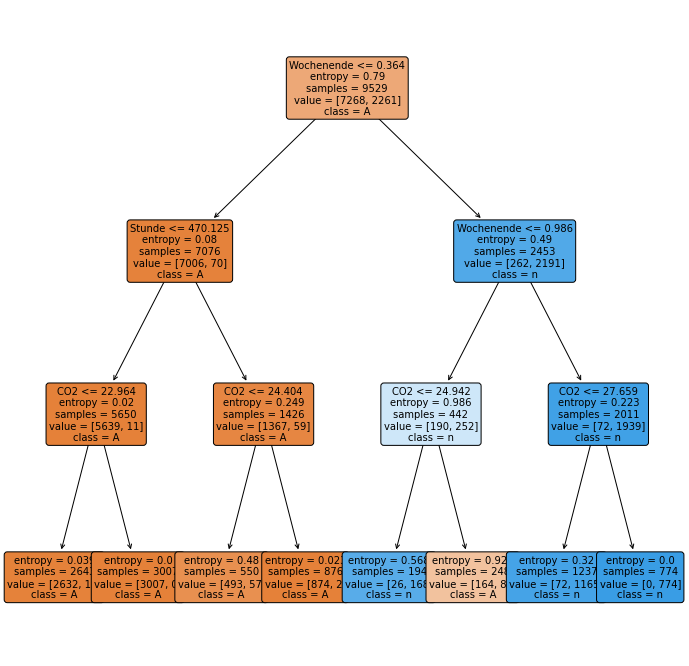

In [ ]:
#train_model(classifier=DecisionTreeClassifier,scaler=MinMaxScaler)
print(pd.DataFrame(columns=df.columns))
mDT = DecisionTreeClassifier(**rsDT.best_params_)
mDT.fit(X_train, y_train)

report(mDT)
plt.figure(figsize=(12,12))
plot_tree(mDT, rounded=True, filled=True, class_names=y.reset_index().columns[1], feature_names=X_name, fontsize=10)
plt.show(mDT)
test_viz(mDT)

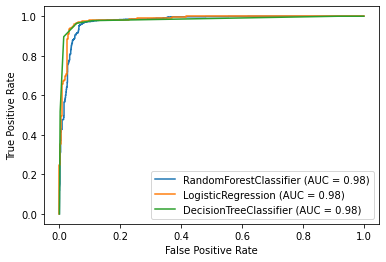

In [ ]:
classifiers = [mRF,mLR,mDT]
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=plt.gca())

In [ ]:
df_temp = pd.DataFrame(df_test.index,index=df_test.index)
df_temp["Anwesenheit"] = (mRF.predict(df_test) + mLR.predict(df_test) + mDT.predict(df_test))/3
#df_temp["CO2"] = df_test["CO2"]
px.bar(df_test.resample("10min").mean(),y="CO2",color=df_temp.resample("10min").mean()["Anwesenheit"])

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for m in [mRF,mLR,mDT]:
    fpr, tpr, _ = roc_curve(y_test,mRF.predict(X_test))
    auc_score = roc_auc_score(y_test,mRF.predict(X_test))
    name = f"{str(m).partition('(')[0]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain')
)
fig.show()

## SVC

In [ ]:
train_model(classifier=SVC,scaler=StandardScaler)

In [ ]:
#!git commit -m "File added"
#!git push

In [ ]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = df.drop(['Anwesenheit'], axis = 1)
y = df['Anwesenheit']
print(X.columns)

# Interaktion
# poly = PolynomialFeatures(interaction_only=True)
# X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC()
grid = {
"C" : [ 0.1, 1, 10],    
"kernel" : ["poly", "rbf", "sigmoid"]
}

clf = GridSearchCV(svc, grid, cv = 5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Arbeitszeit'], dtype='object')
{'C': 10, 'kernel': 'rbf'}
0.9726156751652503


In [ ]:
print(pd.DataFrame(columns=df.columns))
svc = SVC(**clf.best_params_)
svc.fit(X_train, y_train)

report(svc)
df_test_test = df_test.copy()
X_vis = scaler.transform(df_test_test)
df_test_test['Anwesenheit'] = svc.predict(X_vis)
px.bar(df_test_test.resample("10min").mean(),y="CO2",color=df_test_test.resample("10min").mean()["Anwesenheit"])

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.985     0.984     0.985      6953
           1      0.958     0.960     0.959      2576

    accuracy                          0.978      9529
   macro avg      0.971     0.972     0.972      9529
weighted avg      0.978     0.978     0.978      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.987     0.976     0.981      2362
           1      0.932     0.963     0.947       815

    accuracy                          0.973      3177
   macro avg      0.960     0.970     0.964      3177
weighted avg      0.973     0.973     0.973      3177



In [ ]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = df.drop(['Anwesenheit'], axis = 1)
y = df['Anwesenheit']
print(X.columns)

# Interaktion
# poly = PolynomialFeatures(interaction_only=True)
# X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC()
grid = {
"C" : [ 0.1, 1, 10],    
"kernel" : ["poly"],    
"degree" : [1,2,3,4,5]
}

clf = GridSearchCV(svc, grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Arbeitszeit'], dtype='object')
{'C': 10, 'degree': 5, 'kernel': 'poly'}
0.9678942398489141


In [ ]:
print(pd.DataFrame(columns=df.columns))
svc = SVC(**clf.best_params_)
svc.fit(X_train, y_train)

report(svc)
df_test_test = df_test.copy()
X_vis = scaler.transform(df_test_test)
df_test_test['Anwesenheit'] = svc.predict(X_vis)
px.bar(df_test_test.resample("10min").mean(),y="CO2",color=df_test_test.resample("10min").mean()["Anwesenheit"])

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.979     0.986     0.983      6953
           1      0.963     0.943     0.953      2576

    accuracy                          0.975      9529
   macro avg      0.971     0.965     0.968      9529
weighted avg      0.975     0.975     0.975      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.976     0.981     0.978      2362
           1      0.945     0.929     0.937       815

    accuracy                          0.968      3177
   macro avg      0.960     0.955     0.958      3177
weighted avg      0.968     0.968     0.968      3177



# Modell welches die geringsten Kosten verursacht

In [26]:
from sklearn.metrics import f1_score

X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = linear_model.LogisticRegression(max_iter=1000)
random_grid = {
"solver" : ["newton-cg", "lbfgs", "sag" ],
# "penalty" : ["none", "l1", "l2", "elasticnet"],
"C": [100, 10, 1.0, 0.1, 0.01]
}

rsLR =  GridSearchCV(estimator = lr, param_grid = random_grid,
                        cv = 5, verbose=2,  n_jobs = -1)
rsLR.fit(X_train,y_train)
print(rsLR.best_params_,"\n",rsLR.score(X_test, y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'C': 100, 'solver': 'newton-cg'} 
 0.9625432798237331


In [27]:
print(pd.DataFrame(columns=df.columns))
model = linear_model.LogisticRegression(**rsLR.best_params_)
model.fit(X_train, y_train)

report(model)

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.981     0.969     0.975      6953
           1      0.918     0.948     0.933      2576

    accuracy                          0.963      9529
   macro avg      0.949     0.959     0.954      9529
weighted avg      0.964     0.963     0.963      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.985     0.964     0.975      2362
           1      0.902     0.958     0.929       815

    accuracy                          0.963      3177
   macro avg      0.944     0.961     0.952      3177
weighted avg      0.964     0.963     0.963      3177



## Kalkulieren der Kosten mit dem Modell

### Vorbereitung eines Dataframes welcher benutzt wird um die Anzahl an falschen Minuten zu ermitteln sowie die Kosten für die Zeit zu ermitteln.

In [28]:
data = pd.read_csv('train.csv')
data = data[['Datum','Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Anwesenheit']]
data['Datum'] = pd.to_datetime(data['Datum'])
data["Arbeitszeit"] = (data["Datum"].dt.hour.between(8,17))&(data["Datum"].dt.dayofweek < 5)&~((data["Datum"].dt.hour==13)&(data["Datum"].dt.minute.between(0,15)))
data = data.set_index('Datum')
data.dropna(inplace=True)
data['Anwesenheit_pred'] = model.predict(scaler.transform(data.drop(['Anwesenheit'], axis = 1)))
# data['Anwesenheit_pred'] = model.predict(data.drop(['Anwesenheit'], axis = 1))
# df_cost = df_cost.resample('h').mean()
data['Anwesenheit_false'] = (data.Anwesenheit != data.Anwesenheit_pred) & (data.Anwesenheit == 1)

### Ermittlung des anfallenden Kosten in dem Zeitraum

In [30]:
def get_cost(value):
    if value == 0:
        return 0

    else:
        return 5

data_h = data[['Anwesenheit_pred']].resample('h').max()
data_h['Kosten'] = data_h['Anwesenheit_pred'].apply(get_cost)
print('Die Kosten Betragen: ', data_h['Kosten'].sum(), '€')

Die Kosten Betragen:  540 €


## Ermittlung der Fehler in dem Zeitraum

### Dataframe welche die Fehler pro Tag ausgeben

In [ ]:
fehler_tag = data[['Anwesenheit_false']].resample('d').sum()
print(fehler_tag)
fehler_tag[['Anwesenheit_false']].mean()

# -> Metrik suchen! False Negatives

            Anwesenheit_false
Datum                        
2017-01-23                  5
2017-01-24                 44
2017-01-25                 25
2017-01-26                 28
2017-01-27                 20
2017-01-28                  0
2017-01-29                  0
2017-01-30                 17
2017-01-31                  0
2017-02-01                 25
2017-02-02                  0
2017-02-03                  7
2017-02-04                  0


Anwesenheit_false    13.153846
dtype: float64

In [ ]:
t = data[['Anwesenheit_false', 'Anwesenheit']].resample('h').mean()
mask = t.Anwesenheit_false > 0.25
t[mask]

,Anwesenheit_false,Anwesenheit
Datum,,
2017-02-01 18:00:00,0.416667,0.416667


Ergebnisse für die Aufgabe 6:
Ergebnisse mit der Spalte Arbeitszeit
SVC : Kosten = 535€, Abweichung pro Tag = 59 min, false neg = 16.61 pro Tag
Logistic Regression : Kosten = 540€, Abweichung pro Tag = 66 min, false neg = 13.15 min
Decision Tree : Kosten = 625€, Abweichung pro Tag = 66 min, false neg = 10 min
Random Forest : Kosten = 595€, Abweichung pro Tag = 8 min (false)